In [1]:
import os
from sentence_transformers import SentenceTransformer
import numpy as np
import pandas as pd
from openai import OpenAI
from dotenv import load_dotenv
import cv2
from PIL import Image, ImageDraw
from lang_sam import LangSAM
from matplotlib import pyplot as plt

load_dotenv()
sentence_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
options = os.getenv("OPTIONS").split(",")
api_key = os.getenv("OPENAI_API_KEY")
client = OpenAI(api_key=api_key)
features = os.getenv("FEATURES").split(",")

image = cv2.imread("parking2.jpg")
image_height, image_width, _ = image.shape
image_area = image_width * image_height

c:\Python311\Lib\site-packages\sam2\modeling\sam\transformer.py:23: UserWarning: Flash Attention is disabled as it requires a GPU with Ampere (8.0) CUDA capability.
  OLD_GPU, USE_FLASH_ATTN, MATH_KERNEL_ON = get_sdpa_settings()


In [29]:
query = "Give me the number of red cars."

In [3]:
sentence_embedding = sentence_model.encode([query])[0]
options_embeddings = sentence_model.encode(options)

similarities = {}
for i, option in enumerate(options):
    similarity = np.dot(sentence_embedding, options_embeddings[i]) / (np.linalg.norm(sentence_embedding) * np.linalg.norm(options_embeddings[i]))
    similarities[option] = similarity

best_option = max(similarities, key=similarities.get)

print(f"Most Probability world is '{best_option}' with similarity {similarities[best_option]:.4f}")

c:\Python311\Lib\site-packages\transformers\models\bert\modeling_bert.py:439: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


Most Probability world is 'cars' with similarity 0.6176


In [4]:
def get_filter_code(prompt: str) -> str:
    response = client.chat.completions.create(
        model="gpt-4o",
        messages=prompt,
        max_tokens=1000,
        temperature=0,
    )
    
    return response.choices[0].message.content

In [15]:
model_sam = LangSAM()
image_pil = Image.open("parking2.jpg").convert("RGB")
results = model_sam.predict([image_pil], [f"{best_option}."], box_threshold=0.33)

Predicting 1 masks
Predicted 1 masks


In [42]:
result["boxes"]

array([[ 3.66877913e-01, -1.63445234e-01,  6.11466125e+02,
         4.55746643e+02],
       [ 5.27149292e+02,  3.59816101e+02,  5.67865540e+02,
         4.04017273e+02],
       [ 4.37929199e+02,  2.26406265e+02,  4.78234802e+02,
         2.71727234e+02],
       [ 4.19491119e+02, -5.15514314e-02,  4.50285736e+02,
         1.99215622e+01],
       [ 3.74818817e+02,  2.05089966e+02,  4.14744324e+02,
         2.48743973e+02],
       [ 4.94778381e+02,  4.07321838e+02,  5.42429199e+02,
         4.55258209e+02],
       [ 4.85983612e+02,  3.49749908e+02,  5.29465637e+02,
         3.99448578e+02],
       [ 3.81294800e+02,  1.50978394e+02,  4.18504150e+02,
         1.86870926e+02],
       [ 3.39100647e+02,  3.57599243e+02,  3.89017426e+02,
         4.14302277e+02],
       [ 3.47061859e+02,  1.46074188e+02,  3.82655396e+02,
         1.83921967e+02],
       [ 4.04352386e+02,  2.16126801e+02,  4.48101898e+02,
         2.64381897e+02],
       [ 3.05387543e+02,  2.91041718e+02,  3.54890137e+02,
      

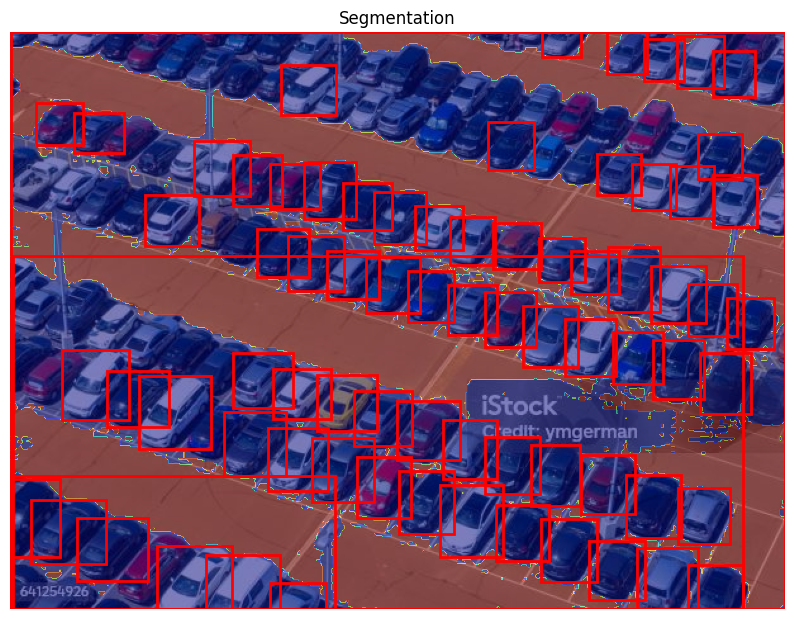

In [16]:
plt.figure(figsize=(10, 10))
plt.imshow(image_pil)
plt.axis('off')
for result in results:
    for box in result["boxes"]:
        x_min, y_min, x_max, y_max = box
        plt.gca().add_patch(plt.Rectangle(
            (x_min, y_min), x_max - x_min, y_max - y_min,
            edgecolor='red', facecolor='none', linewidth=2, label="Box"
        ))

    mask = result["masks"][0]
    plt.imshow(mask, cmap='jet', alpha=0.5)

plt.title("Segmentation")
plt.show()

In [38]:
points_array = np.array([
    [
        [row[0], row[1]],
        [row[2], row[1]],
        [row[2], row[3]],
        [row[0], row[3]]
    ]
    for row in results[0]['boxes']
])

def calculate_features(points, image):
    # Determina i limiti del rettangolo
    x_min = min(p[0] for p in points)
    x_max = max(p[0] for p in points)
    y_min = min(p[1] for p in points)
    y_max = max(p[1] for p in points)

    # Calcola area e dimensioni relative
    area = (x_max - x_min) * (y_max - y_min)
    image_area = image.shape[0] * image.shape[1]
    relative_area = area / image_area
    relative_height = (y_max - y_min) / image.shape[0]
    relative_width = (x_max - x_min) / image.shape[1]

    # Coordinate medie
    mean_x = np.mean([p[0] for p in points])
    mean_y = np.mean([p[1] for p in points])

    # Ritaglia l'area specificata
    cropped_area = image[int(y_min):int(y_max), int(x_min):int(x_max)]

    # Escludi i bordi (considera solo i pixel centrali)
    center_y = cropped_area.shape[0] // 2
    center_x = cropped_area.shape[1] // 2
    offset = min(cropped_area.shape[0] // 4, cropped_area.shape[1] // 4)  # Finestra 10x10 o proporzionale
    cropped_center = cropped_area[
        max(0, center_y - offset):min(center_y + offset, cropped_area.shape[0]),
        max(0, center_x - offset):min(center_x + offset, cropped_area.shape[1])
    ]

    # Converte in formato RGB
    cropped_center_rgb = cv2.cvtColor(cropped_center, cv2.COLOR_BGR2RGB)

    # Filtra pixel con valori estremi (bordi, riflessi)
    filtered_pixels = cropped_center_rgb.reshape(-1, 3)
    filtered_pixels = filtered_pixels[
        (filtered_pixels[:, 0] > 10) & (filtered_pixels[:, 1] > 10) & (filtered_pixels[:, 2] > 10) &  # Evita nero
        (filtered_pixels[:, 0] < 245) & (filtered_pixels[:, 1] < 245) & (filtered_pixels[:, 2] < 245)  # Evita bianco
    ]

    # Calcola la media ponderata dei colori filtrati
    mean_color = np.mean(filtered_pixels, axis=0) if len(filtered_pixels) > 0 else [0, 0, 0]

    # Ritorna le caratteristiche calcolate
    return {
        "coord_1": points[0],
        "coord_2": points[1],
        "coord_3": points[2],
        "coord_4": points[3],
        "mean_x": mean_x,
        "mean_y": mean_y,
        "mean_color_R": mean_color[0],
        "mean_color_G": mean_color[1],
        "mean_color_B": mean_color[2],
        "area": area,
        "relative_area": relative_area,
        "relative_height": relative_height,
        "relative_width": relative_width
    }

dataset = []
for points in points_array:
    features_dict = calculate_features(points, image)
    dataset.append(features_dict)

df = pd.DataFrame(dataset)

df.head()

,coord_1,coord_2,coord_3,coord_4,mean_x,mean_y,mean_color_R,mean_color_G,mean_color_B,area,relative_area,relative_height,relative_width
0,"[0.3668779, -0.16344523]","[611.4661, -0.16344523]","[611.4661, 455.74664]","[0.3668779, 455.74664]",305.916473,227.791595,116.458166,123.519189,123.126470,278606.312500,0.998331,0.999803,0.998528
1,"[527.1493, 359.8161]","[567.86554, 359.8161]","[567.86554, 404.01727]","[527.1493, 404.01727]",547.507446,381.916687,119.582278,149.577215,169.048101,1799.705811,0.006449,0.096932,0.066530
2,"[437.9292, 226.40627]","[478.2348, 226.40627]","[478.2348, 271.72723]","[437.9292, 271.72723]",458.082001,249.066757,117.926282,149.567308,158.939103,1826.688965,0.006546,0.099388,0.065859
3,"[419.49112, -0.05155143]","[450.28574, -0.05155143]","[450.28574, 19.921562]","[419.49112, 19.921562]",434.888428,9.935005,139.937500,164.640625,175.359375,615.064392,0.002204,0.043801,0.050318
4,"[374.81882, 205.08997]","[414.74432, 205.08997]","[414.74432, 248.74397]","[374.81882, 248.74397]",394.781555,226.916962,92.148352,62.796703,73.403846,1742.908325,0.006245,0.095732,0.065238


In [39]:
messages = [
    {"role": "system", "content": "You are an assistant that helps write Python code."},
    {"role": "user", "content": 
    f"""
        Considering the following {df.columns} columns in pandas dataframes. Image dimensions are {image_width}x{image_height} and the area is {image_area}.
        The user's query is: "{query}".

        Write the Python code based on the query and assign to a variable called filtered data noticed that you have to aggregated in some cases. 
        Do not include comments or import statements or library, only the Python code.
        """}
]

try:
    filter_code = get_filter_code(prompt=messages).replace("```python", "").replace("```", "").strip()
    print(filter_code)
    exec(filter_code)
except Exception as e:
    print(f"An error occurred: {e}")

filtered_data = df[(df['mean_color_R'] > df['mean_color_G']) & (df['mean_color_R'] > df['mean_color_B'])]


In [40]:
filtered_data

,coord_1,coord_2,coord_3,coord_4,mean_x,mean_y,mean_color_R,mean_color_G,mean_color_B,area,relative_area,relative_height,relative_width
4,"[374.81882, 205.08997]","[414.74432, 205.08997]","[414.74432, 248.74397]","[374.81882, 248.74397]",394.781555,226.916962,92.148352,62.796703,73.403846,1742.908325,0.006245,0.095732,0.065238
7,"[381.2948, 150.9784]","[418.50415, 150.9784]","[418.50415, 186.87093]","[381.2948, 186.87093]",399.899475,168.924652,139.018809,72.451411,66.413793,1335.537842,0.004786,0.078712,0.060800
11,"[305.38754, 291.04172]","[354.89014, 291.04172]","[354.89014, 338.08356]","[305.38754, 338.08356]",330.138855,314.562622,95.983471,68.117769,82.741736,2328.693115,0.008344,0.103162,0.080887
17,"[273.6778, 335.8259]","[315.88623, 335.8259]","[315.88623, 383.29758]","[273.6778, 383.29758]",294.782013,359.561737,173.190476,123.537815,133.820728,2003.705322,0.007180,0.104105,0.068968
23,"[450.63525, 333.88498]","[492.96817, 333.88498]","[492.96817, 380.35202]","[450.63525, 380.35202]",471.801697,357.118500,97.206549,66.012594,79.002519,1967.085327,0.007049,0.101901,0.069171
34,"[20.174734, 55.76684]","[57.160877, 55.76684]","[57.160877, 88.95177]","[20.174734, 88.95177]",38.667805,72.359299,98.921162,63.663900,86.120332,1227.382446,0.004398,0.072774,0.060435
58,"[241.74876, 271.0913]","[289.14343, 271.0913]","[289.14343, 315.07697]","[241.74876, 315.07697]",265.446106,293.084137,139.655462,126.170868,67.854342,2084.685547,0.007470,0.096460,0.077442
59,"[204.60287, 103.868996]","[244.44861, 103.868996]","[244.44861, 139.69432]","[204.60287, 139.69432]",224.525757,121.781662,107.713178,40.317829,63.860465,1427.486328,0.005115,0.078564,0.065107
65,"[175.7047, 97.08698]","[214.03079, 97.08698]","[214.03079, 137.51239]","[175.7047, 137.51239]",194.867737,117.299683,87.178218,48.128713,70.574257,1549.348022,0.005552,0.088652,0.062624
67,"[0.36301124, 350.47433]","[255.93683, 350.47433]","[255.93683, 455.55]","[0.36301124, 455.55]",128.149933,403.012146,126.320582,109.864033,114.607069,26854.585938,0.096228,0.230429,0.417604


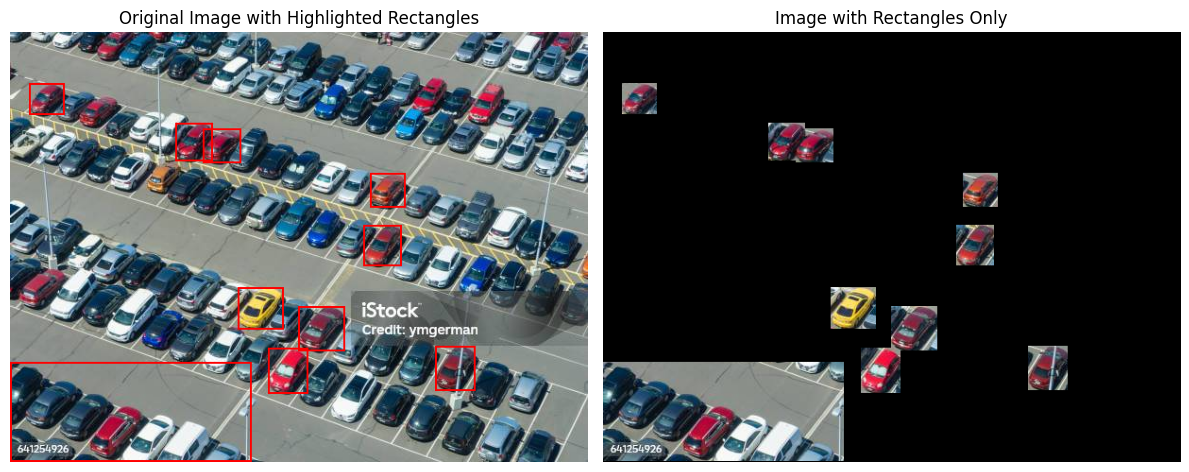

In [41]:
original_image = Image.open("parking2.jpg")

# Copia per disegnare i rettangoli sull'immagine originale
highlighted_image = original_image.copy()
draw = ImageDraw.Draw(highlighted_image)

# Crea un'immagine nera per visualizzare solo i rettangoli
rectangles_image = Image.new("RGB", original_image.size, (0, 0, 0))

# Itera su ogni riga del dataset per ritagliare e disegnare i rettangoli
for _, row in filtered_data.iterrows():
    # Estrai le coordinate come tuple esplicite
    rect_coords = [
        tuple(map(int, row["coord_1"])),
        tuple(map(int, row["coord_2"])),
        tuple(map(int, row["coord_3"])),
        tuple(map(int, row["coord_4"]))
    ]

    # Disegna il rettangolo sull'immagine originale
    draw.polygon(rect_coords, outline="red", width=2)

    # Ritaglia il rettangolo dall'immagine originale
    x1, y1 = rect_coords[0]
    x3, y3 = rect_coords[2]
    cropped_rectangle = original_image.crop((x1, y1, x3, y3))

    # Sovrapponi il rettangolo sull'immagine nera
    rectangles_image.paste(cropped_rectangle, (x1, y1))

# Visualizza le immagini
plt.figure(figsize=(12, 6))

# Immagine originale con rettangoli evidenziati
plt.subplot(1, 2, 1)
plt.imshow(highlighted_image)
plt.title("Original Image with Highlighted Rectangles")
plt.axis("off")

# Immagine composta solo dai rettangoli
plt.subplot(1, 2, 2)
plt.imshow(rectangles_image)
plt.title("Image with Rectangles Only")
plt.axis("off")

plt.tight_layout()
plt.show()